# <div align='center' style='font-size:30px;color:#336699;'>Image Scaling Attacks on Machine Learning Algorithms:  Interpolations 💻</div>

Install required libraries.

In [1]:
!pip install tensorflow-constrained-optimization
!pip install opencv-python
!pip install opencv-contrib-python
!pip install pillow

Import the required libraries.

In [11]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_constrained_optimization as tfco
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import cv2
import numpy as np
import argparse
from pathlib import Path
import os
import sys
import random
from PIL import Image
from keras.applications.resnet50 import preprocess_input

### Functionality and Optimization of Image Scaling Attack

In [4]:
class Problem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, S, T, method, epsilon):
        self._delta = tf.Variable(tf.expand_dims(tf.ones(shape=S.shape, dtype=tf.float32), axis=0), trainable=True, name="delta")
        self._S = tf.expand_dims(tf.convert_to_tensor(S, dtype=tf.float32) / 255, axis=0)
        self._T = tf.expand_dims(tf.convert_to_tensor(T, dtype=tf.float32) / 255, axis=0)
        self._method = method
        self._epsilon = epsilon
        self._delta_shape = self._S.shape
        self._main_constraint = 0
        self._n_constraints = self._T.shape[0] * self._T.shape[1] * self._T.shape[2] * self._T.shape[3] * 2 + 1

    @property
    def num_constraints(self):
        return self._n_constraints

    def objective(self):
        return tf.norm(self._delta, ord='euclidean')

    def constraints(self):
        D = tf.image.resize(self._S + self._delta, size=[self._T.shape[1], self._T.shape[2]], method=self._method)
        main_contraint = tf.norm((D - self._T), ord='euclidean') - self._epsilon
        self._main_constraint = main_contraint
        main_contraint = tf.reshape(main_contraint, shape=(1,1))
        gt_or_eq_to_zero= tf.reshape(-D, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))
        lt_or_eq_to_1= tf.reshape(D - 1, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))

        constraints = tf.concat([main_contraint, gt_or_eq_to_zero, lt_or_eq_to_1], axis=0)
        constraints = tf.reshape(constraints, shape=(constraints.shape[0]))
        return constraints
        
def optimize(S, T, method, epsilon, iterations):
    problem = Problem(S, T, method, epsilon)
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = problem.objective()
            constraints = problem.constraints()
            
            # Adding a term to the loss for any constraints that are violated.
            loss += tf.reduce_sum(tf.nn.relu(constraints))

        gradients = tape.gradient(loss, [problem._delta])
        optimizer.apply_gradients(zip(gradients, [problem._delta]))

        if i % 1000 == 0:
            print(f'[*] Step = {i}')
            print("\t\t[*] Modification size: ", problem.objective().numpy())
            print("\t\t[*] Difference between the modified image (A) and target image: ", problem._main_constraint.numpy())

    # Modified image
    A = problem._S[0] + problem._delta[0]
    return A

Select any source image *(S)* and a target image *(T)* for the attack.

In [92]:
# Source image (S)
source_path = '/70.png'

# Target image (T)
target_path = '/Stop.png'

In [93]:
def show_image(image_path):
    img = image.load_img(image_path)
    img_tensor = image.img_to_array(img)
    img_tensor /= 255
    plt.imshow(img_tensor)
    print(img_tensor.shape)

(889, 1400, 3)


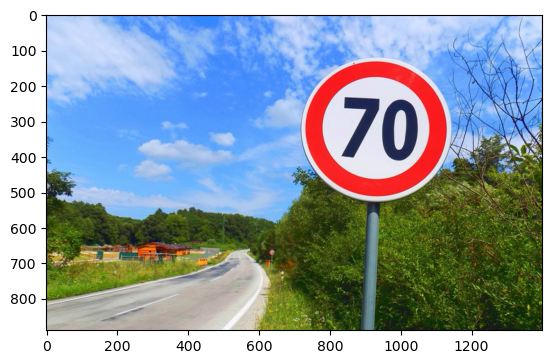

In [94]:
# Source image (S)
show_image(source_path)

(54, 54, 3)


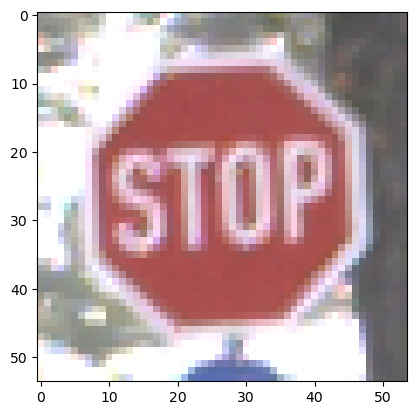

In [95]:
# Target image (T)
show_image(target_path)

In [96]:
def load_image(tam):
    img = image.load_img(source_path, target_size=(tam, tam))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    return img_tensor

### Attack Modes
* #### Attack mode 1:

     Checks if the test image classifies under the given false classification label.

* #### Attack mode 2:

     Checks if the test image classifies under any label except the given correct classification label.

### Attack Execution

Finds the image size of the ML model for German Traffic Sign Recognition Benchmark (GTSRB), and attempts an image scaling attack to check vulnerable interpolation techniques.

Attacking the model... trying to find out the size of model inputs...

1/1 [==============================] - 0s 120ms/step
--- The shape of their model inputs is (30, 30, 3) --- 

Now checking interpolation method...

CHOICE ---> bilinear

[*] Step = 0
		[*] Modification size:  1931.7217
		[*] Difference between the modified image (A) and target image:  50.3755
[*] Step = 1000
		[*] Modification size:  1614.0558
		[*] Difference between the modified image (A) and target image:  0.2512675
[*] Step = 2000
		[*] Modification size:  1298.6553
		[*] Difference between the modified image (A) and target image:  3.4175813e-05
[*] Step = 3000
		[*] Modification size:  983.782
		[*] Difference between the modified image (A) and target image:  -0.029886216


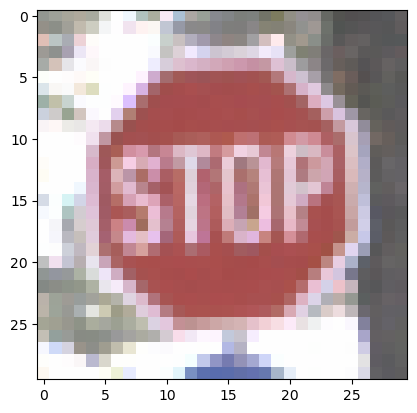

1/1 [==============================] - 0s 24ms/step

This is a Stop signal.

-----------------

CHOICE ---> lanczos3

[*] Step = 0
		[*] Modification size:  1931.8304
		[*] Difference between the modified image (A) and target image:  50.40986
[*] Step = 1000
		[*] Modification size:  1616.8108
		[*] Difference between the modified image (A) and target image:  0.0070875287
[*] Step = 2000
		[*] Modification size:  1301.9933
		[*] Difference between the modified image (A) and target image:  0.0126663
[*] Step = 3000
		[*] Modification size:  987.81683
		[*] Difference between the modified image (A) and target image:  -0.0078042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


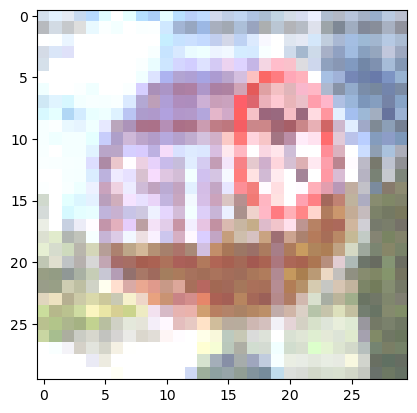

1/1 [==============================] - 0s 25ms/step

This is a Stop signal.

-----------------

CHOICE ---> lanczos5

[*] Step = 0
		[*] Modification size:  1931.8381
		[*] Difference between the modified image (A) and target image:  50.42319
[*] Step = 1000
		[*] Modification size:  1617.0051
		[*] Difference between the modified image (A) and target image:  0.0034279525
[*] Step = 2000
		[*] Modification size:  1302.4523
		[*] Difference between the modified image (A) and target image:  0.008005619
[*] Step = 3000
		[*] Modification size:  988.6225
		[*] Difference between the modified image (A) and target image:  -0.013380997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


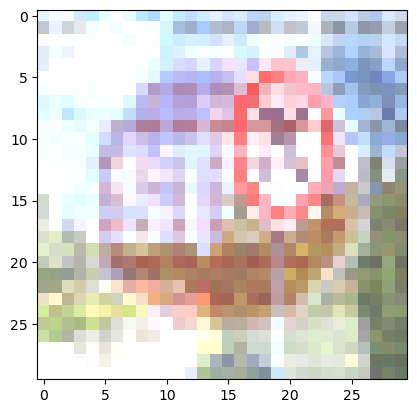

1/1 [==============================] - 0s 27ms/step

This is a Veh > 3.5 tons prohibited signal.

-----------------

CHOICE ---> bicubic

[*] Step = 0
		[*] Modification size:  1931.7966
		[*] Difference between the modified image (A) and target image:  50.397934
[*] Step = 1000
		[*] Modification size:  1616.1711
		[*] Difference between the modified image (A) and target image:  0.0044180527
[*] Step = 2000
		[*] Modification size:  1300.9491
		[*] Difference between the modified image (A) and target image:  -0.010788292
[*] Step = 3000
		[*] Modification size:  986.24396
		[*] Difference between the modified image (A) and target image:  -0.01259011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


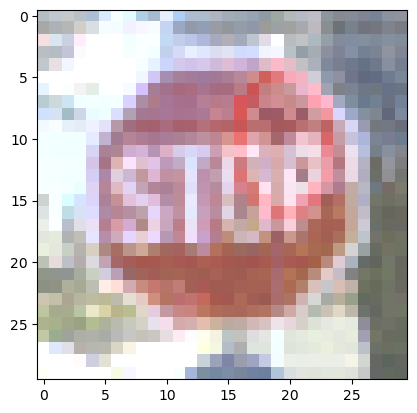

1/1 [==============================] - 0s 25ms/step

This is a Keep left signal.

-----------------

CHOICE ---> gaussian

[*] Step = 0
		[*] Modification size:  1931.6802
		[*] Difference between the modified image (A) and target image:  50.363567
[*] Step = 1000
		[*] Modification size:  1613.0769
		[*] Difference between the modified image (A) and target image:  1.7786561
[*] Step = 2000
		[*] Modification size:  1297.7711
		[*] Difference between the modified image (A) and target image:  -0.026571326
[*] Step = 3000
		[*] Modification size:  983.0035
		[*] Difference between the modified image (A) and target image:  -0.006373115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


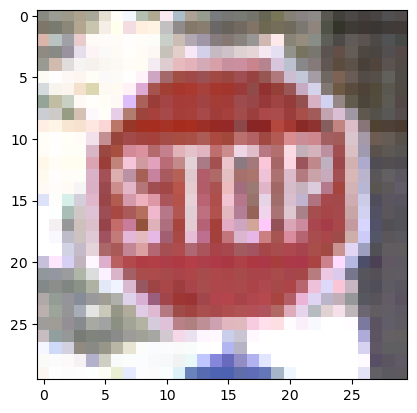

1/1 [==============================] - 0s 25ms/step

This is a Go straight or left signal.

-----------------

CHOICE ---> nearest

[*] Step = 0
		[*] Modification size:  1931.8655
		[*] Difference between the modified image (A) and target image:  50.428684
[*] Step = 1000
		[*] Modification size:  1615.433
		[*] Difference between the modified image (A) and target image:  -0.021012627
[*] Step = 2000
		[*] Modification size:  1299.9031
		[*] Difference between the modified image (A) and target image:  -0.0118917525
[*] Step = 3000
		[*] Modification size:  984.8373
		[*] Difference between the modified image (A) and target image:  0.00062649697


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


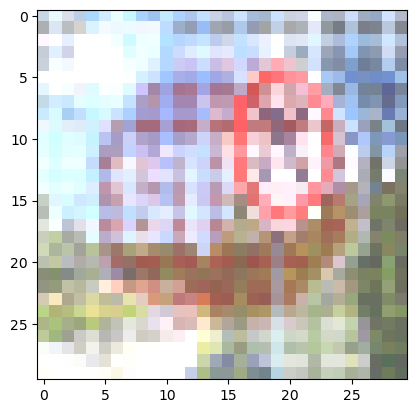

1/1 [==============================] - 0s 24ms/step

This is a Dangerous curve left signal.

-----------------

CHOICE ---> mitchellcubic

[*] Step = 0
		[*] Modification size:  1931.7357
		[*] Difference between the modified image (A) and target image:  50.381565
[*] Step = 1000
		[*] Modification size:  1614.8353
		[*] Difference between the modified image (A) and target image:  -0.0041712224
[*] Step = 2000
		[*] Modification size:  1299.4574
		[*] Difference between the modified image (A) and target image:  -0.022969447
[*] Step = 3000
		[*] Modification size:  984.6018
		[*] Difference between the modified image (A) and target image:  -0.02123557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


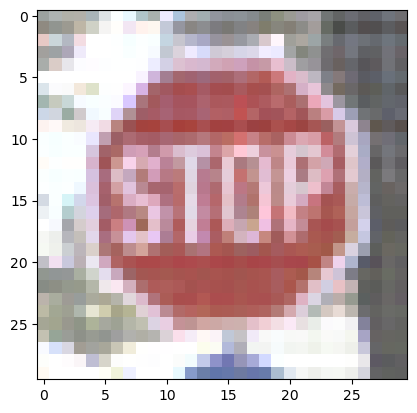

1/1 [==============================] - 0s 25ms/step

This is a Stop signal.

-----------------



In [98]:
print("Attacking the model!")
print("Finding the size of model inputs...\n")

for size in range(1, 2000):
    model = tf.keras.models.load_model('GTSRB model.keras')
    image_tensor = load_image(size)

    try:
        preds = model.predict(image_tensor)
    except:
        continue

    break

attack_shape = image_tensor.shape[1:]
print(f"--- The shape of their model inputs is {attack_shape} --- \n")
print("Now checking interpolation method...\n")

S = cv2.cvtColor(cv2.imread(source_path, 1), cv2.COLOR_BGR2RGB)
T = cv2.cvtColor(cv2.imread(target_path, 1), cv2.COLOR_BGR2RGB)
T = cv2.resize(T, (attack_shape[0], attack_shape[1]))

choices = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest','mitchellcubic']
chosen = []
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

for choice in choices:
    print(f"CHOICE ---> {choice}\n")
    A = optimize(S, T, choice, 0.1, 4000)
    D = tf.image.resize(tf.expand_dims(A, axis=0), size=[T.shape[0], T.shape[1]])[0]

    D_expanded = np.expand_dims(D, axis=0)
    D_expanded = D_expanded * 255
    D_expanded = D_expanded.astype(np.uint8) / 1

    plt.imshow(D)
    plt.show()

    prediction = model.predict(D_expanded)
    prediction = np.argmax(prediction)

    print()
    print(f"This is a {class_names[prediction]} signal.\n")

    if class_names[prediction] == 'Stop': chosen.append(choice)

    print("-----------------\n")

### Vulnerablities

In [99]:
print(f"The model is vulnerable to size {attack_shape} and methods of interpolation {chosen}")

The model is vulnerable to size (30, 30, 3) and methods of interpolation ['bilinear', 'lanczos3', 'mitchellcubic']


Effect of quality of the scaled image using different interpolation techniques.

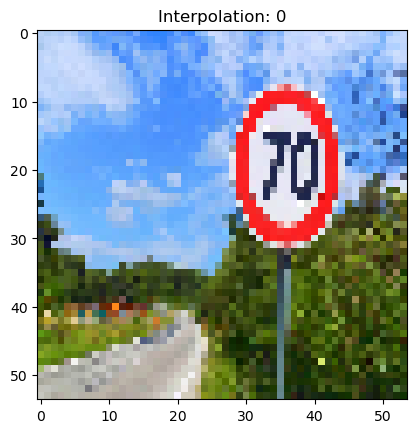

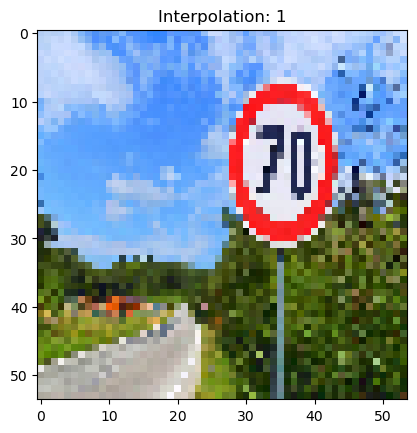

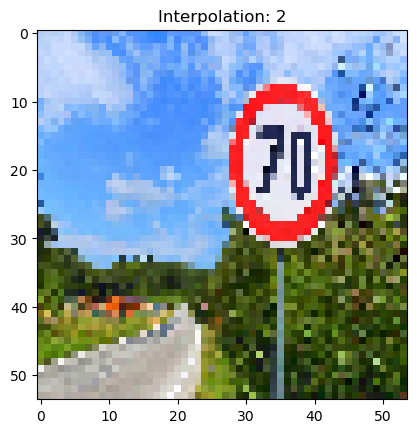

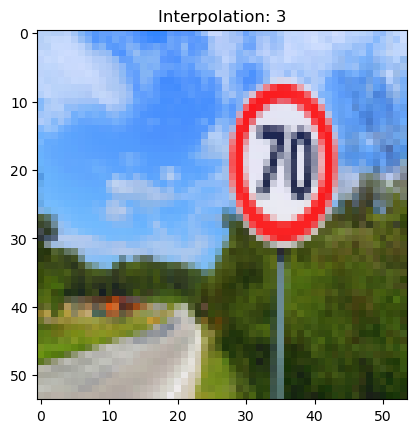

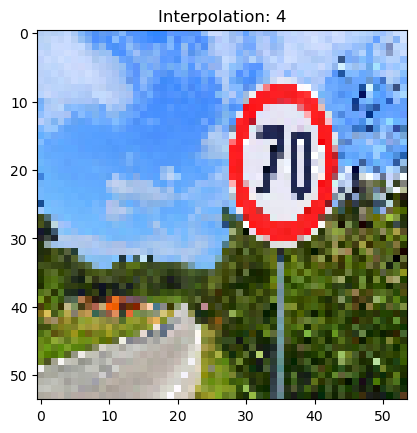

In [101]:
source_image = cv2.imread('/70.png', 1)
target_image = cv2.imread('/Stop.png', 1)

methods = [
    cv2.INTER_NEAREST,  # Nearest-neighbor interpolation
    cv2.INTER_LINEAR,   # Bilinear interpolation
    cv2.INTER_CUBIC,    # Bicubic interpolation
    cv2.INTER_AREA,     # Resampling using pixel area relation
    cv2.INTER_LANCZOS4  # Lanczos interpolation over 8x8 pixel neighborhood
]

for method in methods:
    resized_image = cv2.resize(source_image, (target_image.shape[0], target_image.shape[1]), interpolation=method)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Interpolation: {method}')
    plt.axis()
    plt.show()